In [ ]:
# ..... clustering with Monocle3? ..... #

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(monocle3)
library(mclust)

In [3]:
# assign majority cell type label to cluster
get_cluster_label <- function(vec1, ctype1){
    cluster_list = unique(vec1)
    cluster_label = ctype1
    
    for(ii in 1:length(cluster_list)){
        ids = which(vec1==cluster_list[ii])
        cluster_label[ids] = names(which.max(table(ctype1[ids])))
    }
    
    return(cluster_label)
}

In [5]:
# list of stages and samples
stages = rep(c('stage14', 'stage17', 'stage21'), each = 3)
samples = paste0('sample', c('4', '7', '8A', '3_Triangle', '5B', '5Y', '1A', '1B', '2'))
qiu_stage = c('E9.5', 'E9.5', 'E9.5', 'E10.5', 'E10.5', 'E10.5', 'E11.5', 'E11.5', 'E11.5')

In [6]:
# load data
pb = txtProgressBar(min = 0, max = length(stages), initial = 0)

for(id in 1:length(stages)){
    
    sc1 = readRDS(paste0(stages[id], '_', samples[id], '_data.rds'))
    sc1$dataset = paste0('s', sub('\\.*sample', '', samples[id]))

    # get expr data for monocle
    expression_matrix = GetAssayData(sc1, 'counts')
    gene_df = data.frame(gene_short_name = rownames(expression_matrix))
    rownames(gene_df) = rownames(expression_matrix)

    cds <- new_cell_data_set(expression_matrix,
                             cell_metadata = sc1@meta.data,
                             gene_metadata = gene_df)

    ## Step 1: Normalize and pre-process the data
    cds <- preprocess_cds(cds, num_dim = 100)
    
    ## Step 3: Reduce the dimensions using UMAP
    cds <- reduce_dimension(cds)

    ## Step 4: Cluster the cells
    cds <- cluster_cells(cds)
    
    
    ## get other cluster labels
    # load SHC clusters too
    load(paste0(stages[id], '_', samples[id], '_clusters_SHC.Rdata'))
    cds$shc_clusters = clusters[[1]]

    # get updated cluster list
    m1 = read.delim(paste0(stages[id], '_', samples[id], '_Qiu_', qiu_stage[id], '_celltypes.csv'), sep = ',')
    ids = match(m1$barcode, colnames(cds))
    m1$shc_cluster = cds$shc_clusters
    m1$monocle_cluster = cds@clusters@listData$UMAP$clusters
    # m1[1,]
    
    
    ## get majority cluster label
    m1$shc_label = get_cluster_label(m1$shc_cluster, m1$class)
    m1$monocle_label = get_cluster_label(m1$monocle_cluster, m1$class)
    print(adjustedRandIndex(m1$shc_label, m1$monocle_label))
    setTxtProgressBar(pb, id)

    # save
    write.table(m1, file = paste0(stages[id], '_', samples[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',',
                row.names = F, col.names = T, quote = F)
}

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8718289

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.7403821

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8413982

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8623676

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8517468

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.9090288

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8125562

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8901222

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.6799725

In [9]:
# make one file per stage
df = c()
for(id in 7:9){
    temp = read.delim(paste0(stages[id], '_', samples[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    temp$stage = stages[id]
    temp$sample = samples[id]
    df = rbind(df, temp)
}
write.table(df, file = paste0(stages[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',',
                row.names = F, col.names = T, quote = F)

In [10]:
df[1,]

barcode                             class    celltype   final_celltype
1 stage21_sample1A_AAACCCAAGATAACAC-1 Mesoderm Sclerotome Sclerotome    
  shc_cluster monocle_cluster shc_label monocle_label stage   sample  
1 4           4               Mesoderm  Mesoderm      stage21 sample1A

In [64]:
# plot summaries
id = 9
df = read.delim(paste0(stages[id], '_', samples[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')

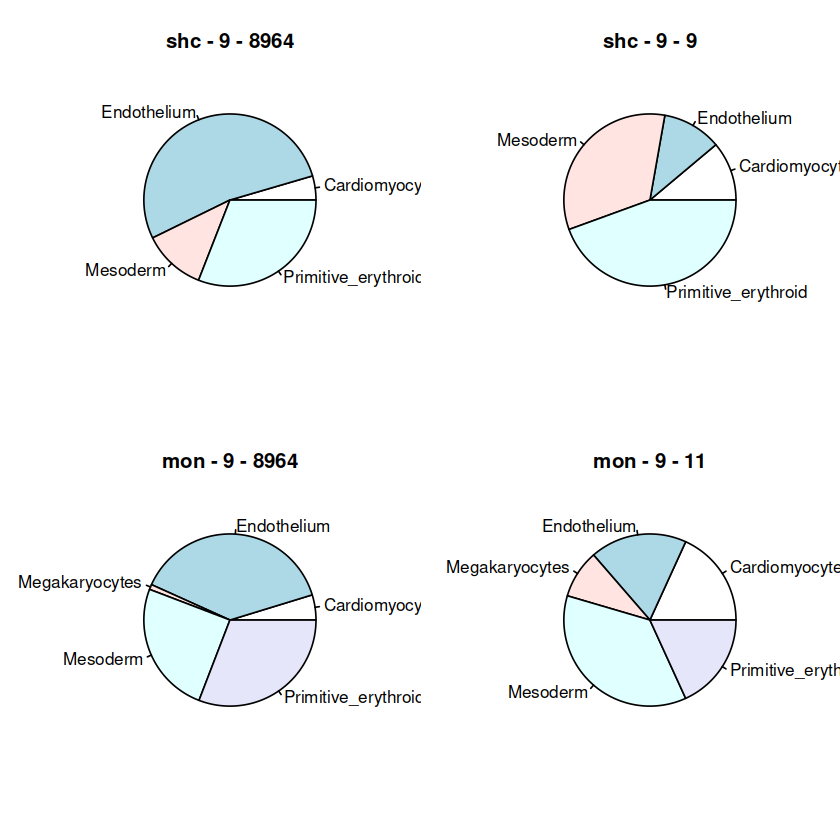

In [66]:
newdf1 = data.frame(df %>% group_by(shc_label) %>% summarise(count = n()))
newdf2 = data.frame(df %>% group_by(shc_label) %>% summarise(count = length(unique(shc_cluster))))
newdf3 = data.frame(df %>% group_by(monocle_label) %>% summarise(count = n()))
newdf4 = data.frame(df %>% group_by(monocle_label) %>% summarise(count = length(unique(monocle_cluster))))

# pdf(paste0('aa-', id, '-pies-shc-mon.pdf'), width = 8, height = 8)
par(mfrow = c(2,2))
pie(newdf1$count, labels = newdf1$shc_label, main = paste0('shc - ', id, ' - ', dim(df)[1])) 
pie(newdf2$count, labels = newdf2$shc_label, main = paste0('shc - ', id, ' - ', length(unique(df$shc_cluster))))
pie(newdf3$count, labels = newdf3$monocle_label, main = paste0('mon - ', id, ' - ', dim(df)[1]))
pie(newdf4$count, labels = newdf4$monocle_label, main = paste0('mon - ', id, ' - ', length(unique(df$monocle_cluster))))
# dev.off()